In [111]:
import re
import numpy as np
import pandas as pd

import math
import matplotlib.pyplot as plt

from collections import Counter
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.datasets import make_classification

from sklearn.pipeline import Pipeline

from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier 

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as confusion_matrix

In [2]:
# loads all the training data here
df_train1 = pd.read_table("./test_data/raw_data_70_new.csv", sep=",")
df_train2 = pd.read_table("./test_data/raw_data_30_new.csv", sep=",")
df_train_data = pd.concat([df_train1, df_train2])

df_train_enquiry1 = pd.read_table("./test_data/raw_enquiry_70_new.csv", sep=",")
df_train_enquiry2 = pd.read_table("./test_data/raw_enquiry_30_new.csv", sep=",")
df_train_enquiry = pd.concat([df_train_enquiry1, df_train_enquiry2])
df_train_enquiry.fillna(0, inplace=True)

df_train_account1 = pd.read_table("./test_data/raw_account_70_new.csv", sep=",")
df_train_account2 = pd.read_table("./test_data/raw_account_30_new.csv", sep=",")
df_train_account = pd.concat([df_train_account1, df_train_account2])

/home/ubuntu/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (12,20,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ubuntu/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# conversion of dates to timestamp formats
df_train_data['dt_opened'] = pd.to_datetime(df_train_data['dt_opened'])
df_train_data['entry_time'] = pd.to_datetime(df_train_data['entry_time'])
df_train_data['feature_2'] = pd.to_datetime(df_train_data['feature_2'])
df_train_data['feature_21'] = pd.to_datetime(df_train_data['feature_21'])
df_train_data['feature_53'] = pd.to_datetime(df_train_data['feature_53'])
df_train_data['feature_54'] = pd.to_datetime(df_train_data['feature_54'])

df_train_enquiry['dt_opened'] = pd.to_datetime(df_train_enquiry['dt_opened'])
df_train_enquiry['upload_dt'] = pd.to_datetime(df_train_enquiry['upload_dt'])
df_train_enquiry['enquiry_dt'] = pd.to_datetime(df_train_enquiry['enquiry_dt'])

df_train_account['dt_opened'] = pd.to_datetime(df_train_account['dt_opened'])
df_train_account['upload_dt'] = pd.to_datetime(df_train_account['upload_dt'])
df_train_account['opened_dt'] = pd.to_datetime(df_train_account['opened_dt'])
df_train_account['last_paymt_dt'] = pd.to_datetime(df_train_account['last_paymt_dt'])
df_train_account['closed_dt'] = pd.to_datetime(df_train_account['closed_dt'])
df_train_account['reporting_dt'] = pd.to_datetime(df_train_account['reporting_dt'])
df_train_account['paymt_str_dt'] = pd.to_datetime(df_train_account['paymt_str_dt'])
df_train_account['paymt_end_dt'] = pd.to_datetime(df_train_account['paymt_end_dt'])

In [31]:
def check_dtd29(payment_history):
    return bool(re.match(r"[A-Z, 0]*[1-9]+[A-Z, 0]*", payment_history))

def check_min_dtd29(payment_history):
    payment_tokens = re.findall('...',payment_history)    
    for index, each_token in enumerate(payment_tokens):
        if bool(re.match(r"[0]*[1-9]+[0]*", each_token)):
            return (index + 1)
    return 10000

def get_accounts_dtd29(g):
    return g[g.dtd29 == True].count()/g['dtd29'].count()   

def get_accounts_min_dtd29(g):
    return g['min_dtd29'].min()

def gini(y_actual, y_pred):
    return 2*roc_auc_score(y_actual, y_pred)-1

# Transforms the accounts data
tot_balence=df_train_account.groupby(by=['customer_no'])['cur_balance_amt'].sum()
tot_credit_limit=df_train_account.groupby(by=['customer_no'])['creditlimit'].sum()
tot_cash_limit=df_train_account.groupby(by=['customer_no'])['cashlimit'].sum()
num_accounts = df_train_account.groupby(by=['customer_no']).size()

df_train_account['paymenthistory2'].fillna("", inplace=True)
df_train_account['paymenthistory1'] = df_train_account['paymenthistory2'].map(str) + df_train_account['paymenthistory1'].map(str)
df_train_account['paymenthistory1'] = df_train_account['paymenthistory1'].str.replace('"','')
payment_history_temp = df_train_account[['customer_no', 'paymenthistory1']]

df = df_train_account
payment_history_temp['dtd29'] = payment_history_temp.apply(lambda x: check_dtd29(x['paymenthistory1']), axis=1)
payment_history_temp['min_dtd29'] = payment_history_temp.apply(lambda x: check_min_dtd29(x['paymenthistory1']), axis=1)

df_train_account_dtd = payment_history_temp.groupby('customer_no').apply(get_accounts_dtd29)
df_train_account_d = df_train_account_dtd[['dtd29']]

df_train_account_min_dtd = payment_history_temp.groupby('customer_no').apply(get_accounts_min_dtd29)
df_train_account_ratio_balence_credit = tot_balence / tot_credit_limit
df_train_account_utilization = (df_train_account_ratio_balence_credit / (tot_balence / (tot_credit_limit + tot_cash_limit)))

df_train_account_transform = pd.concat([df_train_account_d, df_train_account_min_dtd, df_train_account_ratio_balence_credit, df_train_account_utilization], axis=1, join='inner')
df_train_account_transform = df_train_account_transform.replace([np.inf, -np.inf], np.nan)
df_train_account_transform.fillna(0, inplace=True)

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# Transforms the enquiry data
def get_top_occur(g):
    return g['enq_purpose'].value_counts().idxmax()    

df_train_enquiry_90 = df_train_enquiry[(df_train_enquiry['upload_dt'] - df_train_enquiry['enquiry_dt']).dt.days < 90]
df_train_enquiry_90 = df_train_enquiry_90.groupby('customer_no').size()

df_train_enquiry_365 = df_train_enquiry[(df_train_enquiry['upload_dt'] - df_train_enquiry['enquiry_dt']).dt.days < 365]
df_train_enquiry_365 = df_train_enquiry_365.groupby('customer_no').size()

df_train_enquiry['open'] = ((df_train_enquiry['dt_opened'] - df_train_enquiry['enquiry_dt']).dt.days)
df_train_enquiry_open = df_train_enquiry.groupby('customer_no').mean()
df_train_enquiry_o = df_train_enquiry_open[['open']]

df_train_enquiry_occur = df_train_enquiry.groupby('customer_no').apply(get_top_occur)

df_train_enquiry_transform = pd.concat([df_train_enquiry_90, df_train_enquiry_365, df_train_enquiry_occur, df_train_enquiry_o], axis=1, join='inner')

In [67]:
df_train_partial_data = pd.merge(df_train_data, df_train_account_transform, how='inner' , left_on='customer_no', right_on='customer_no')
df_train_partial_data_2 = pd.merge(df_train_partial_data, df_train_enquiry_transform, how='outer' , left_on='customer_no', right_on='customer_no')
df_train_partial_data_2.fillna("0", inplace=True)

#float_list = ['0_y', '1_y', '2_y', 'open']
#df_train_partial_data_2[float_list] = df_train_partial_data_2[float_list].astype('float64')

df_train_target = df_train_partial_data_2['Bad_label']
#df_train_partial_data_2 = df_train_partial_data_2.drop(['Bad_label'], axis=1)

In [7]:
# convert categorical data
le = preprocessing.LabelEncoder()

#list_objects = df_train_partial_data.dtype
object_list = list(df_train_partial_data_2.select_dtypes(include=['object', 'datetime64[ns]']))

In [8]:
# Fit the encoder object (le) to a pandas field with categorical data
df_train_partial_data_2[object_list] = df_train_partial_data_2[object_list].astype(str)
df_train_partial_data_2[object_list] = df_train_partial_data_2[object_list].apply(le.fit_transform)

In [17]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(df_train_partial_data_2, df_train_target, test_size=test_size, random_state=seed)

from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 21861, 1: 21861})


In [16]:
model = LogisticRegression()
rfe = RFE(model, 50)
fit = rfe.fit(X_res, y_res)

[[6715 4094]
 [ 181  275]]
Test set AUC: 0.612


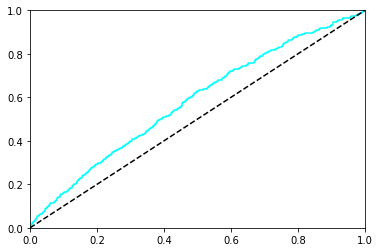

             precision    recall  f1-score   support

          0       0.97      0.62      0.76     10809
          1       0.06      0.60      0.11       456

avg / total       0.94      0.62      0.73     11265

[[6715 4094]
 [ 181  275]]


In [30]:
auc_score = roc_auc_score(y_test, fit.predict(X_test))
gini_score = gini(y_test, fit.predict(X_test))

if auc_score < 0.5:
    fpr_svc, tpr_svc, _ = roc_curve(y_test, pipe.predict_proba(X_test)[:,1], pos_label=0)
    auc_score = 1 - auc_score
else:
    fpr_svc, tpr_svc, _ = roc_curve(y_test, pipe.predict_proba(X_test)[:,1])

print(confusion_matrix(y_test, fit.predict(X_test)))
print("Test set AUC: {:.3f}".format(auc_score))   
#print("Gini score: {:.3f}".format(gini_score))   

plt.plot(fpr_svc, tpr_svc, label='ROC Curve', color='cyan')
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

default_prob = fit.predict_proba(X_test)[:,1]
confusion_mat = confusion_matrix(y_test, fit.predict(X_test))
results = classification_report(y_test, fit.predict(X_test))

print(results)
print(confusion_mat)

In [33]:
from xgboost import XGBClassifier
import random

xclas = XGBClassifier() 
xgb_parms = {'learning_rate': 0.1, 'subsample': 0.6, 
             'colsample_bylevel': 0.6, 'silent': True, 'objective': 'reg:linear'}

xdata = xclas.fit(X_res, y_res)
y_pred = xclas.predict(X_test.values)

auc_score = roc_auc_score(y_test, y_pred)
gini_score = gini(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(auc_score)
print(gini_score)

ImportError: No module named 'xgboost'

In [ ]:
plt.hist(df_train_partial_data_2[df_train_partial_data_2['Bad_label'] == 0].iloc[:,89], bins=50)
plt.hist(df_train_partial_data_2[df_train_partial_data_2['Bad_label'] == 1].iloc[:,89], bins=50)

In [37]:
df_train_partial_data_2

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_78,feature_79,dtd29,0_x,1_x,2_x,0_y,1_y,2_y,open
0,1,1,48,2,34,47,2,1,1,419,...,1,1,0.294118,1,25.655041,1.118839,0,0,0,0
1,2,1,52,2,38,123,1,1,1,30,...,1,1,0.294118,1,25.655041,1.118839,0,0,0,0
2,2,2,56,2,42,157,1,1,1,30,...,1,1,0.000000,10000,0.030678,1.000001,12,12,10,13869
3,19,2,71,2,57,240,1,1,1,223,...,1,1,0.000000,10000,0.030678,1.000001,12,12,10,13869
4,3,3,56,2,42,171,1,1,1,468,...,1,1,0.416667,2,19.422849,1.520482,1,1,7,5308
5,27,3,85,2,71,120,3,1,1,64,...,1,1,0.416667,2,19.422849,1.520482,1,1,7,5308
6,6,4,50,2,41,167,1,1,1,419,...,1,1,0.142857,2,2.374862,1.376076,0,0,0,0
7,28,4,87,2,73,175,1,1,1,169,...,1,1,0.142857,2,2.374862,1.376076,0,0,0,0
8,14,5,65,2,0,1,3,1,1,419,...,1,1,0.076923,1,0.141180,1.598958,0,0,0,0
9,28,5,77,2,64,207,1,1,1,419,...,2,1,0.076923,1,0.141180,1.598958,0,0,0,0


In [35]:
fit.ranking_

array([10, 36, 11,  1, 14, 13,  1,  1,  1, 21,  1,  1,  1,  1,  1, 16,  1,
       27, 22, 20,  1,  1, 31, 34, 28,  1, 23,  1,  1,  1,  5, 19,  1,  1,
        1,  1,  1, 35,  9,  4, 38,  1,  1,  1, 12,  8, 37, 40,  1, 32,  3,
        1,  1,  1, 25, 18,  1,  1,  7,  6,  1,  1,  1,  1,  1,  2,  1, 30,
       26,  1,  1, 33, 24,  1,  1,  1,  1,  1,  1, 29,  1,  1,  1, 39, 15,
        1,  1, 17,  1, 41])

In [112]:
def entropy(data, target_attr):
    val_freq = {}
    data_entropy = 0.0
 
    # Calculate the frequency of each of the values in the target attr
    
    for index, record in data.iterrows():
        if (record[target_attr] in val_freq ):
            val_freq[record[target_attr]] += 1.0
        else:
            val_freq[record[target_attr]]  = 1.0
 
    # Calculate the entropy of the data for the target attribute
    for freq in val_freq.values():
        data_entropy += (-freq/len(data)) * math.log(freq/len(data), 2) 
    return data_entropy

In [148]:
def gain(data, attr, target_attr):
    val_freq = {}
    subset_entropy = 0.0
 
    # Calculate the frequency of each of the values in the target attribute
    for index, record in data.iterrows():
        if (record[attr] in val_freq) :
            val_freq[record[attr]] += 1.0
        else:
            val_freq[record[attr]]  = 1.0
 
    # Calculate the sum of the entropy for each subset of records weighted by their probability of occuring in the training set.
    for val in val_freq.keys():
        val_prob = val_freq[val] / sum(val_freq.values())        
        data_subset = data.loc[data.iloc[:,attr] == val]
        subset_entropy += val_prob * entropy(data_subset, target_attr) 
    # Subtract the entropy of the chosen attribute from the entropy of the whole data set with respect to the target attribute (and return it)
    return (entropy(data, target_attr) - subset_entropy)
for ind

In [156]:
for index, record in df_train_partial_data_2.iterrows():
    print(index, gain(df_train_partial_data_2, index, 82))

0 0.005813509483271778
1 0.20595592530376441
2 0.006272821289072944
3 0.0012810149613323163
4 0.006668154163494505
5 0.008435296152642463
6 0.0004924755478524223
7 2.0399699374173963e-08
8 2.0399699374173963e-08
9 0.011896852824375997
10 0.0005963763298749702
11 0.0005963763298749702
12 0.00013185621252881363
13 6.656406203403575e-05
14 0.0020986313237866816
15 0.0010167008642560371
16 0.0012247414996960915
17 0.007743802022938756
18 0.011004128137256874
19 0.003681312712427276
20 7.444005709500434e-05
21 2.2447876555864443e-05
22 0.14607617104641377
23 0.11832350730191613
24 0.04781565321821293
25 0.0002305029702531769
26 0.008561669940119004
27 0.00027671717676902574
28 0.0006071346942944089
29 0.0004033637488615738
30 0.0018420322586666371
31 0.016717088638818767
32 0.0011088536567388507
33 0.00013369915250044384
34 2.7419045702969935e-05
35 3.123725878872996e-05
36 0.00027307977466123345
37 0.05218904625862744
38 0.00035490612195349103
39 0.0005319306093368725
40 0.0697643671983271

IndexError: index out of bounds